# LSTM with Attention on FGSA Dataset

## Imports and Loading Data

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load adversarial data
adv_train = pd.read_csv("/content/drive/MyDrive/models/data/adversarial_train_samples.csv")
adv_test = pd.read_csv("/content/drive/MyDrive/models/data/adversarial_test_samples.csv")

# Assuming the last column is the label and the rest are features
x_train_adv = adv_train.iloc[:, :-1].values  # Features
y_train_adv = adv_train.iloc[:, -1].values   # Labels
x_test_adv = adv_test.iloc[:, :-1].values    # Features
y_test_adv = adv_test.iloc[:, -1].values     # Labels

Using device: cuda


In [ ]:
# Normalize features
scaler = StandardScaler()
x_train_adv = scaler.fit_transform(x_train_adv)
x_test_adv = scaler.transform(x_test_adv)

# Reshape for LSTM: (num_samples, seq_length, num_features)
x_train_adv = x_train_adv.reshape((x_train_adv.shape[0], 1, x_train_adv.shape[1]))
x_test_adv = x_test_adv.reshape((x_test_adv.shape[0], 1, x_test_adv.shape[1]))

# Convert numpy arrays to PyTorch tensors
x_train_adv_tensor = torch.tensor(x_train_adv, dtype=torch.float32).to(device)
x_test_adv_tensor = torch.tensor(x_test_adv, dtype=torch.float32).to(device)
y_train_adv_tensor = torch.tensor(y_train_adv, dtype=torch.float32).to(device)
y_test_adv_tensor = torch.tensor(y_test_adv, dtype=torch.float32).to(device)

# Create DataLoader for adversarial data
train_adv_dataset = TensorDataset(x_train_adv_tensor, y_train_adv_tensor)
test_adv_dataset = TensorDataset(x_test_adv_tensor, y_test_adv_tensor)

train_adv_loader = DataLoader(train_adv_dataset, batch_size=64, shuffle=True)
test_adv_loader = DataLoader(test_adv_dataset, batch_size=64, shuffle=False)

## Defining LSTM with Attention

In [ ]:
class Attention(nn.Module):
    def __init__(self, hidden_dim):
        super(Attention, self).__init__()
        self.W = nn.Linear(hidden_dim, hidden_dim)
        self.v = nn.Parameter(torch.randn(hidden_dim))

    def forward(self, hidden_states):
        scores = torch.tanh(self.W(hidden_states))
        scores = torch.matmul(scores, self.v.unsqueeze(0).unsqueeze(-1)).squeeze(-1)
        attn_weights = torch.softmax(scores, dim=1)
        context = torch.bmm(attn_weights.unsqueeze(1), hidden_states).squeeze(1)
        return context

class LSTMWithAttention(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=1):
        super(LSTMWithAttention, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.attention = Attention(hidden_dim)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        attn_out = self.attention(lstm_out)
        out = self.fc(attn_out)
        return out

## Training Model

In [ ]:
# Model parameters
input_dim = x_train_adv_tensor.shape[2]  # Number of features
hidden_dim = 128
output_dim = 1  # Binary classification
num_layers = 1

# Initialize the model
model = LSTMWithAttention(input_dim, hidden_dim, output_dim, num_layers).to(device)

def train_model(model, train_loader, num_epochs=10, learning_rate=0.001):
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)

            # Compute predictions and accuracy
            predicted = (torch.sigmoid(outputs.squeeze()) > 0.5).float()
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_accuracy = correct / total
        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}")

    print("Training complete.")

# Training the model on adversarial data
train_model(model, train_adv_loader)

Epoch 1/10, Loss: 0.0137, Accuracy: 0.9960
Epoch 2/10, Loss: 0.0020, Accuracy: 0.9994
Epoch 3/10, Loss: 0.0011, Accuracy: 0.9997
Epoch 4/10, Loss: 0.0008, Accuracy: 0.9998
Epoch 5/10, Loss: 0.0005, Accuracy: 0.9999
Epoch 6/10, Loss: 0.0003, Accuracy: 0.9999
Epoch 7/10, Loss: 0.0002, Accuracy: 0.9999
Epoch 8/10, Loss: 0.0002, Accuracy: 1.0000
Epoch 9/10, Loss: 0.0001, Accuracy: 1.0000
Epoch 10/10, Loss: 0.0001, Accuracy: 1.0000
Training complete.


## Evaluating Model

Confusion Matrix:
[[56852    11]
 [    8 56855]]

Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     56863
         1.0       1.00      1.00      1.00     56863

    accuracy                           1.00    113726
   macro avg       1.00      1.00      1.00    113726
weighted avg       1.00      1.00      1.00    113726



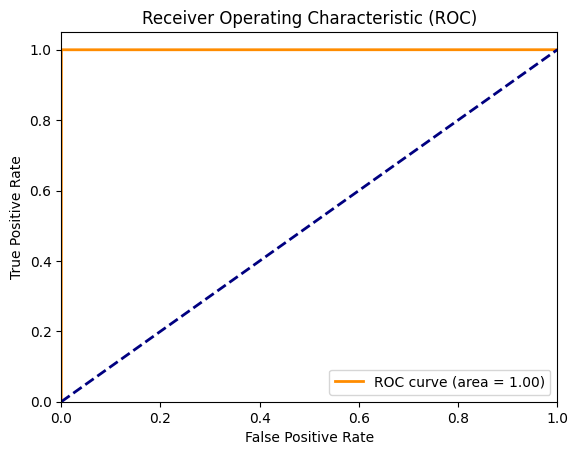

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc

def evaluate_model(model, test_loader):
    model.eval()
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            predicted = (torch.sigmoid(outputs.squeeze()) > 0.5).float()
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    all_labels = np.array(all_labels)
    all_preds = np.array(all_preds)

    # Compute metrics
    conf_matrix = confusion_matrix(all_labels, all_preds)
    class_report = classification_report(all_labels, all_preds)

    # ROC Curve
    fpr, tpr, _ = roc_curve(all_labels, all_preds)
    roc_auc = auc(fpr, tpr)

    # Print confusion matrix and classification report
    print("Confusion Matrix:")
    print(conf_matrix)
    print("\nClassification Report:")
    print(class_report)

    # Plot ROC Curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc='lower right')
    plt.show()

# Use the evaluate_model function with adversarial test data
evaluate_model(model, test_adv_loader)

In [ ]:
# Save the model
model_path = "adv_lstm_attention_model.pth"
torch.save(model.state_dict(), model_path)
print(f"Model saved to {model_path}")

Model saved to adv_lstm_attention_model.pth
